# Benchmark com Microsoft GrabCut (50 imagens)

Utilizando a métrica _error rate_, esse notebook propõe-se construir uma avaliação no dataset grabcut para avaliar a taxa de erro médio para o algoritmo EGSIS. A intenção é realizar uma comparação com as técnicas avaliadas no artigo _Segmentation by t

O. Duchenne, J. -Y. Audibert, R. Keriven, J. Ponce and F. Segonne, "Segmentation by transduction," 2008 IEEE Conference on Computer Vision and Pattern Recognition, Anchorage, AK, USA, 2008, pp. 1-8, doi: 10.1109/CVPR.2008.4587419.

In [1]:
import os
os.environ["LOGURU_LEVEL"] = "ERROR"

In [2]:
from egsis.datasets import grabcut
import matplotlib.pyplot as plt
from egsis import model
from egsis import metrics

# Avaliação única aleatória

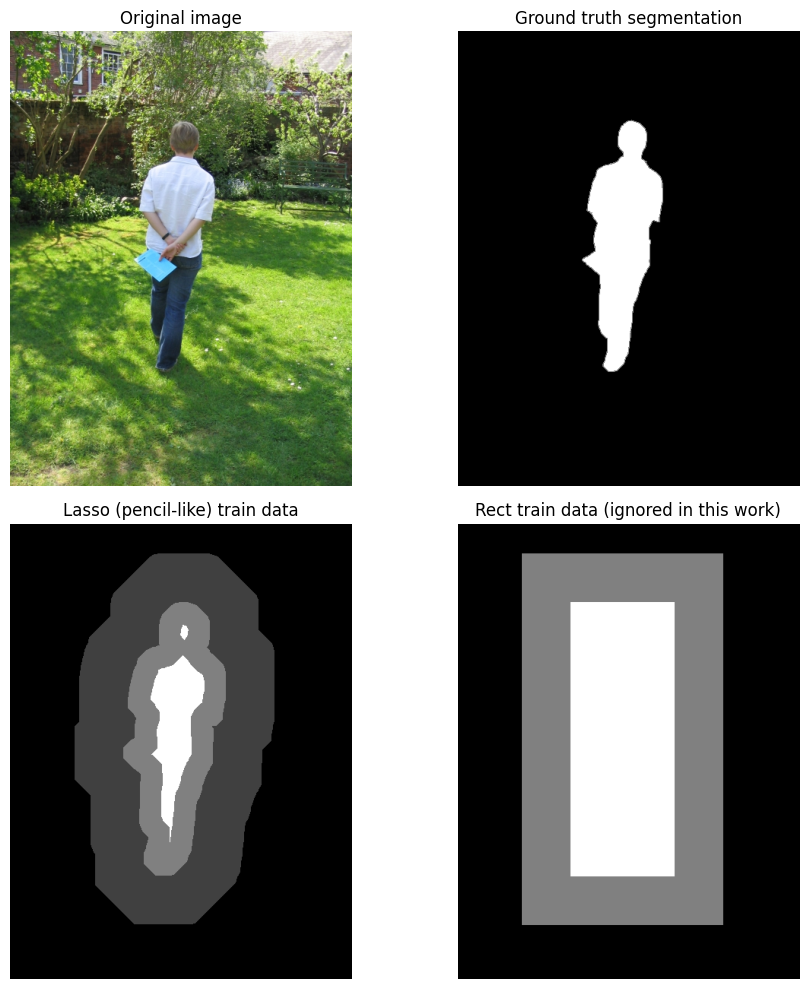

In [3]:
img = grabcut.get_random_image()
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0, 0].imshow(img.data)
ax[0, 0].set_title("Original image")
ax[0, 1].imshow(img.segmentation, cmap="gray")
ax[0, 1].set_title("Ground truth segmentation")
ax[1, 0].imshow(img.lasso, cmap="gray")
ax[1, 0].set_title("Lasso (pencil-like) train data")
ax[1, 1].imshow(img.rect, cmap="gray")
ax[1, 1].set_title("Rect train data (ignored in this work)")


for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

# Labelling description 

**Segmentation**: A tri-map which specifies background (0), foreground (255) and
mixed area (128). The mixed area contains pixels which are a combination of foreand background texture. Note, in low contrast regions the true boundary is not
observed and the ground truth is in this case a "good guess".

**Labelling-Lasso**: Imitates a tri-map obtained by a lasso or pen tool. The colour
coding is: 

- background (0);
- background - used for colour model training (64);
- inference (unknown) region (128);
- foreground - used for colour model training (255).

Note, a lasso tool can be imitated by specifying the foreground region (255) as unknown
(128).

**Labelling-Rectangle**: Imitates a tri-map obtained by two mouse clicks (rectangle).
Same colour coding as in Labelling-Lasso.

In [4]:
# Preprocessing labeling scheme
# y_train = img.lasso
# y_train[y_train == 64] = 1 # background
# y_train[y_train == 128] = 0 # means unlabelled for egsis
# y_train[y_train == 255] = 2 # foreground
# y_true = img.segmentation
# y_true[y_true == 128] = 1
# y_true[y_true == 255] = 1

# not more necessary the steps above, replaced by:
y_train = img.y_train()
y_true = img.y_true()

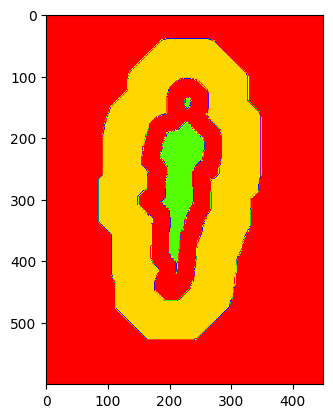

In [5]:
plt.imshow(y_train, cmap="prism")  

# the green region it's training data for background
# the yellow region it's training data for foreground

(-0.5, 449.5, 599.5, -0.5)

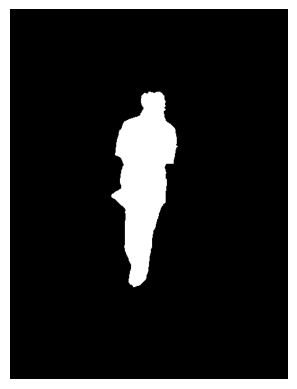

In [6]:
X = img.data
y = y_train

m = model.EGSIS(
    superpixel_segments=200,
    superpixel_sigma=0.8,
    superpixel_compactness=40,
    feature_extraction="gabor",
    lcu_max_iter=100,
    feature_similarity="manhattan_log",
)

# Fit predict receiving a image mask
# re-encoding y-values to be in {0,1} because for EGSIS, y=0 means non-labeled
mask = m.fit_predict_segmentation_mask(X, y) - 1
plt.imshow(mask, cmap="gray")
plt.axis('off')

In [7]:
y_train.shape

(600, 450)

In [8]:
X.shape

(600, 450, 3)

In [9]:
import numpy as np
np.unique(y_train)

array([0, 1, 2], dtype=uint8)

In [10]:
y_pred = mask
err = metrics.err(y_true, y_pred) * 100
iou = metrics.iou(y_true, y_pred)
f1 = metrics.f1(y_true, y_pred)
acc = metrics.pixel_accuracy(y_true, y_pred)
print("Segmentation Metrics!")
print(f"Err:\t{round(err, 2)}%") 
print(f"IoU:\t{round(iou, 2)}") 
print(f"F1:\t{round(f1, 2)}") 
print(f"acc:\t{round(acc, 2)}") 

Segmentation Metrics!
Err:	1.17%
IoU:	0.94
F1:	0.07
acc:	1.0


# Avaliação em Lote

In [11]:
%%time
import pandas as pd
imgs = grabcut.get_all_dataset()
stats = []
for img in imgs:
    X = img.data
    y_true = img.y_true()
    y_train = img.y_train()
    mask = m.fit_predict_segmentation_mask(X, y_train)
    # label re-encoding
    y_pred = mask - 1
    err = metrics.err(y_true, y_pred) * 100
    iou = metrics.iou(y_true, y_pred)
    f1 = metrics.f1(y_true, y_pred)
    acc = metrics.pixel_accuracy(y_true, y_pred)
    stat = [img.fname, err, iou, f1, acc]
    stats.append(stat)

df = pd.DataFrame(stats, columns=["name", "err", "iou", "f1", "acc"])
df

CPU times: user 31min 5s, sys: 17min 24s, total: 48min 30s
Wall time: 18min 16s


,name,err,iou,f1,acc
0,memorial.jpg,7.465723,0.838126,0.170556,0.967059
1,person1.jpg,1.664428,0.956610,0.281548,0.987230
2,271008.jpg,2.495042,0.859746,0.123749,0.979812
3,sheep.jpg,2.892506,0.852249,0.048281,0.991630
4,person3.jpg,9.797645,0.848172,0.093748,0.983219
5,153093.jpg,3.519167,0.742223,0.096580,0.966457
6,banana2.bmp,1.859485,0.872134,0.218187,0.968011
7,doll.bmp,2.629873,0.948419,0.361015,0.980366
8,stone1.JPG,2.802298,0.958663,0.191527,0.991742
9,21077.jpg,6.960774,0.825004,0.104028,0.977934


In [12]:
df.describe()

,err,iou,f1,acc
count,50.000000,50.000000,50.000000,50.000000
mean,3.500609,0.851110,0.191378,0.972924
std,2.942950,0.094226,0.113308,0.013442
min,0.014807,0.613558,0.048281,0.930318
25%,1.669651,0.802636,0.107540,0.962792
50%,2.531025,0.871250,0.165974,0.972995
75%,5.070694,0.932385,0.233636,0.981796
max,12.489079,0.958663,0.526473,0.995693


In [23]:
df.sort_values(by="err")

,name,err,iou,f1,acc
32,flower.jpg,0.014807,0.887225,0.177567,0.977430
48,fullmoon.bmp,0.020511,0.894494,0.056393,0.993348
39,teddy.jpg,0.078633,0.892234,0.190884,0.976945
46,elefant.bmp,0.214447,0.933273,0.310915,0.977770
24,227092.jpg,0.274781,0.910698,0.376675,0.963064
14,388016.jpg,0.466721,0.736457,0.118076,0.957746
27,tennis.jpg,0.536308,0.613558,0.055072,0.965314
13,person4.jpg,0.607412,0.947088,0.177204,0.990100
15,stone2.JPG,0.685319,0.940688,0.234388,0.985221
41,86016.jpg,1.004174,0.925416,0.153730,0.987610
